# Real example
original data: jobs logs from cluster

In [1]:
import socket
import os
import sys
import bz2

if sys.version_info[0] < 3:
    from StringIO import StringIO
else:
    from io import StringIO

#print os.path.dirname(sys.argv[0])

def printlogs(files=[],limit=3):
    print "first "+str(limit)+" of " + str(len(files)) 
    for fname in files[:limit]:
        print fname    

folder='/statistics'        
if socket.gethostname().find('.')>=0:
    my_hostname=socket.gethostname()
else:
    my_hostname=socket.gethostbyaddr(socket.gethostname())[0]
if len(my_hostname.split('.')) > 1 :
    if my_hostname.split('.')[1] == 'pico' :
        folder="/cineca/usr/acct/statistics"
jobs=os.listdir(folder)
jobs.sort()
printlogs(jobs)


first 3 of 149
20150112.jobs.bz2
20150113.jobs.bz2
20150114.jobs.bz2


now we filter file jobs, decompress into string and look at the first line

In [2]:


startstring='2015'
selected_jobs = [j for j in jobs if j.endswith('.bz2') and 
              j.startswith(startstring)]
printlogs(selected_jobs)

for f in selected_jobs[:3]:
    bzf=bz2.BZ2File(os.path.join(folder,f))
    content=bzf.read()
    bzf.close()
    lines=content.split('\n')
    print lines[0]



first 3 of 149
20150112.jobs.bz2
20150113.jobs.bz2
20150114.jobs.bz2
20150112;5932;360000;700;1;4300800;parallel;333959;0;0;cin_staff;mcestari
20150113;6222;259200;60;1;138240;parallel;92024;1;0;cin_staff;rpieri00
20150114;6293[1];259200;8;1;48128;epigen;119459;6526;0;EPIGE_prod;a07epg01


Now merge all lines into the same dataframe, with predefined fields

In [3]:
import pandas as pd

fields=['date',
        'jobid',
        'wcl',
        'cpu',
        'aff',
        'mem',
        'queue',
        'elapsed',
        'waited',
        'status',
        'account',
        'username',
        'dummy1',
        'dummy2']

Cluster=pd.DataFrame()
for f in selected_jobs:
    bzf=bz2.BZ2File(os.path.join(folder,f))
    content=bzf.read()
    bzf.close()
    DATA=StringIO(content)
    #print DATA
    df_day=pd.read_csv(
        DATA,
        sep=';',
        header=None,
        names=fields,
        parse_dates=['date']
    )
    Cluster=pd.concat([Cluster,df_day])
print "number of records: "+str(len(Cluster))
Cluster.info()
Cluster.head()
#Cluster.tail()

number of records: 66077
<class 'pandas.core.frame.DataFrame'>
Int64Index: 66077 entries, 0 to 566
Data columns (total 14 columns):
date        66077 non-null datetime64[ns]
jobid       66077 non-null object
wcl         66077 non-null int64
cpu         66077 non-null int64
aff         66077 non-null int64
mem         66077 non-null int64
queue       66077 non-null object
elapsed     66077 non-null int64
waited      66077 non-null int64
status      66077 non-null int64
account     66077 non-null object
username    66077 non-null object
dummy1      22564 non-null float64
dummy2      22797 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(7), object(4)
memory usage: 7.6+ MB


date jobid     wcl  cpu  aff      mem     queue  elapsed  waited  \
0 2015-01-12  5932  360000  700    1  4300800  parallel   333959       0   
1 2015-01-12  6181   21600    1    1     2048  meteoser      587       1   
2 2015-01-12  6182   21600  140    1   716800     R6008        2     576   
3 2015-01-12  6183   21600    1    1     2048  meteoser    13786       1   
4 2015-01-12  6184   21600  140    1   716800     R6008     1433       0   

   status    account  username  dummy1  dummy2  
0       0  cin_staff  mcestari     NaN     NaN  
1      15   smr_prod  a07smr01     NaN     NaN  
2      15   smr_prod  a07smr01     NaN     NaN  
3       0   smr_prod  a07smr01     NaN     NaN  
4       0   smr_prod  a07smr01     NaN     NaN

Do some inspection

In [6]:
pd.set_option('max_rows', 5)
#Cluster

Cluster.tail()

date     jobid    wcl  cpu  aff    mem        queue  elapsed  \
562 2015-06-09  52547[1]  82800    4    1  16384       epigen     2394   
563 2015-06-09  52547[2]  82800    4    1  16384       epigen     3826   
564 2015-06-09  52548[0]  43200    3    1  16384  epigen_dbio        1   
565 2015-06-09  52548[1]  43200    3    1  16384  epigen_dbio        1   
566 2015-06-09  52548[2]  43200    3    1  16384  epigen_dbio     1170   

     waited  status     account  username  dummy1  dummy2  
562       0       0  EPIGE_prod  a07epg01       0       0  
563       0       0  EPIGE_prod  a07epg01       0       0  
564       0       0  EPIGE_prod  a07epg01       0       0  
565       1       0  EPIGE_prod  a07epg01       0       0  
566       1       0  EPIGE_prod  a07epg01       0       0

In [7]:
Cluster['core_hours'] = Cluster['cpu'] * Cluster['elapsed'] / 3600
Cluster

date     jobid     wcl  cpu  aff      mem        queue  elapsed  \
0   2015-01-12      5932  360000  700    1  4300800     parallel   333959   
1   2015-01-12      6181   21600    1    1     2048     meteoser      587   
..         ...       ...     ...  ...  ...      ...          ...      ...   
565 2015-06-09  52548[1]   43200    3    1    16384  epigen_dbio        1   
566 2015-06-09  52548[2]   43200    3    1    16384  epigen_dbio     1170   

     waited  status     account  username  dummy1  dummy2    core_hours  
0         0       0   cin_staff  mcestari     NaN     NaN  64936.472222  
1         1      15    smr_prod  a07smr01     NaN     NaN      0.163056  
..      ...     ...         ...       ...     ...     ...           ...  
565       1       0  EPIGE_prod  a07epg01       0       0      0.000833  
566       1       0  EPIGE_prod  a07epg01       0       0      0.975000  

[66077 rows x 15 columns]

In [8]:
relevant=dict()
for f in fields: 
    v=Cluster[f].value_counts()
    print "different_values of "+\
          f+"  "+str(len(v))+" "+\
          str(v.mean())+" "+\
          str(v.min())+" "+\
          str(v.max())+" "
    #relevant[f]=v[()]
v=Cluster['queue'].value_counts()
v
relev=[]
for k in v.keys():
    if v[k] > 0.1*v.mean() : relev.append(k)
print relev
#relevant=dict()
#for f in ['queue','account']: 
#    g=Cluster.groupby('queue')
#used_queue=[]
#for q in g.group


different_values of date  149 443.469798658 47 2428 
different_values of jobid  66076 1.00001513409 1 2 
different_values of wcl  65 1016.56923077 1 21543 
different_values of cpu  53 1246.73584906 1 12012 
different_values of aff  1 66077.0 66077 66077 
different_values of mem  108 611.824074074 1 8911 
different_values of queue  312 211.78525641 1 34018 
different_values of elapsed  11460 5.76588132635 1 5771 
different_values of waited  8921 7.40690505549 1 18501 
different_values of status  4 16519.25 1 61868 
different_values of account  34 1943.44117647 1 20950 
different_values of username  113 584.752212389 1 21328 
different_values of dummy1  1 22564.0 22564 22564 
different_values of dummy2  3 7599.0 1 22795 
['parallel', 'epigen', 'meteoser', 'serial', 'epigen_dbio', 'rcm_visual', 'dcv_visual', 'meteo', 'R15024', 'bigmem', 'system', 'R38006', 'R45731', 'R32345']



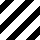
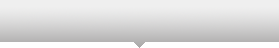
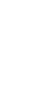
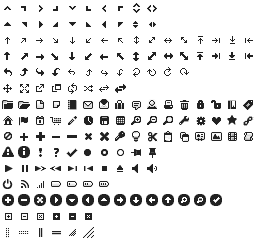
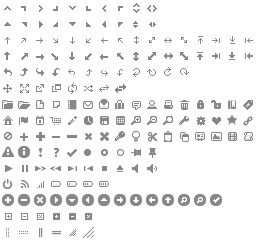
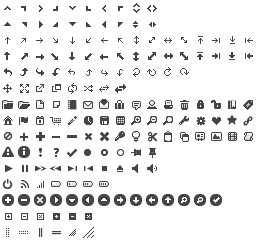
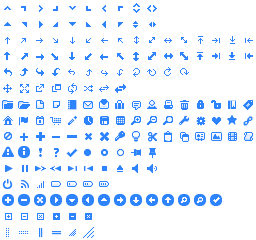
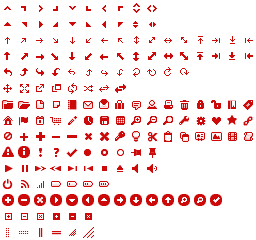
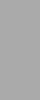
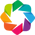
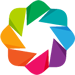
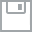
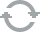
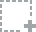
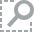
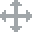
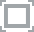
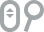


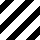
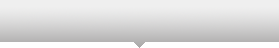
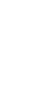
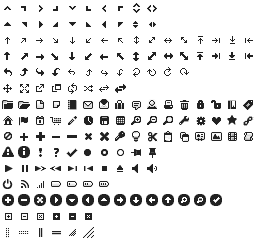
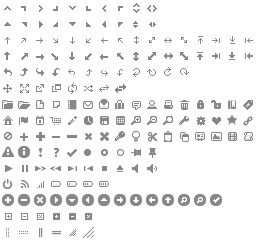
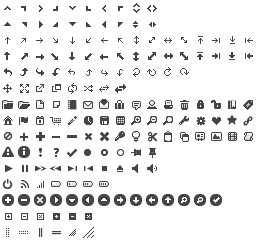
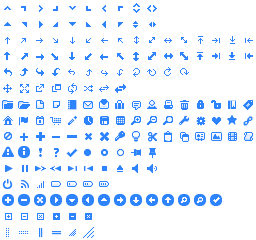
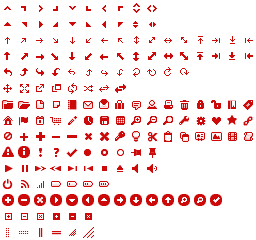
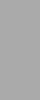
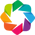
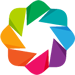
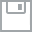
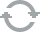
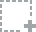
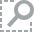
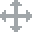
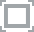
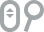

In [12]:
import numpy as np
#import bokeh.plotting as bp
import bokeh
import bokeh.charts
import bokeh.plotting
from bokeh.models import HoverTool 
bokeh.charts.output_notebook()
bokeh.plotting.output_notebook()
#bp.output_file('test.html')
#import matplotlib.pyplot as plt

import numpy
import random
from collections import OrderedDict
import pandas as pd

# skip site cert check
#http://stackoverflow.com/questions/27835619/ssl-certificate-verify-failed-error
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
#ssl.create_default_context(capath=False)
'''
Cluster = pd.read_csv(
    "https://hpc-forge.cineca.it/files/Visualization_School/public/20150315.jobs",
    sep=';',
    header=None,
    names=['date',
           'jobid',
           'wcl',
           'cpu',
           'aff',
           'mem',
           'queue',
           'elapsed',
           'waited',
           'status',
           'account',
           'username','unknown'],
    parse_dates=['date'])
'''
sel = Cluster[['elapsed','waited', "queue"]]
#print sel
grouped_df=sel.groupby("queue")
pdict = OrderedDict()




In [10]:
fig1 = bokeh.plotting.figure(tools="reset,hover,pan,wheel_zoom")
x1 = np.linspace(0,2*np.pi)
x2 = np.linspace(0,2.3*np.pi)
y1 = np.sin(x1)
y2 = np.cos(x2)
s1 = fig1.scatter(x=x1,y=y1,color='#0000ff',size=10,legend='sine')
#s1.select(dict(type=HoverTool)).tooltips = {"x":"$x", "y":"$y"}
s2 = fig1.scatter(x=x2,y=y2,color='#ff0000',size=10,legend='cosine')
#s2.select(dict(type=HoverTool)).tooltips = OrderedDict([("x","@x"),("y","@y")])
s3 = fig1.scatter(x=x2,y=y1,color='#00ffff',size=10,legend='sineooo')
#s3.select(dict(type=HoverTool)).tooltips = {"xx":"$x", "y":"$y"}
s4 = fig1.scatter(x=x1,y=y2,color='#ffff00',size=10,legend='cccosine')
s4.select(dict(type=HoverTool)).tooltips = OrderedDict([("ddx","@x"),("y","@y")])
bokeh.charts.show(fig1)

In [13]:
fig = bokeh.plotting.figure(tools="reset,hover,pan,wheel_zoom")
#fig.background_fill = "black"
s=dict()
ctot=0
colors=dict()
colors[0]='#ff0000'
colors[1]='#00ff00'
colors[2]='#0000ff'
colors[3]='#ff00ff'
colors[4]='#00ffff'
colors[5]='#ffff00'
for i in grouped_df.groups.keys():
#  print i
#  if  i =='debug' or i == 'smallpar':
#  if  i =='debug' :
#  if  i =='debug' or i == 'longdebug':
#  if  i =='debug' or i == 'serial':
#  if  i =='parallel' or i == 'smallpar':
#  if  i =='serial' or i == 'bigpar' or i == 'longdebug':
#  if  i =='serial' or i == 'smallpar' or i == 'longdebug':
#  if  i =='debug' or i == 'smallpar' or i == 'longdebug':
#  if  i =='debug' or i == 'smallpar' or i == 'bigpar':
#  if  i =='serial' or i == 'smallpar' or i == 'bigpar':
    ctot = ctot +1
    p = sel[(sel.queue == i)][['elapsed','waited']]
    a=p.values
#    x=p[['elapsed']].values
#    y=p[['waited']].values
    x=a[:,0]
    y=a[:,1]
    #print len(a)
    #print x
    #c=plt.cm.RdYlBu((ctot*100)%256)
    #cc=(int(c[0]*256),int(c[1]*256),int(c[2]*256),c[3])
    s[i] = fig.scatter(x=x,
                    y=y,
                    color=colors.get(ctot,'#000000'),
                    size=5,
                    legend=i+ ' '+str(len(a)))
    s[i].select(dict(type=HoverTool)).tooltips = {"x":"@x", "y":"$y"}
    
bokeh.charts.show(fig)